In [271]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import minimize
from scipy.stats import chi2

In [272]:
## Cargo archivos

x, n, k = np.loadtxt('eficiencia.dat', unpack = True)

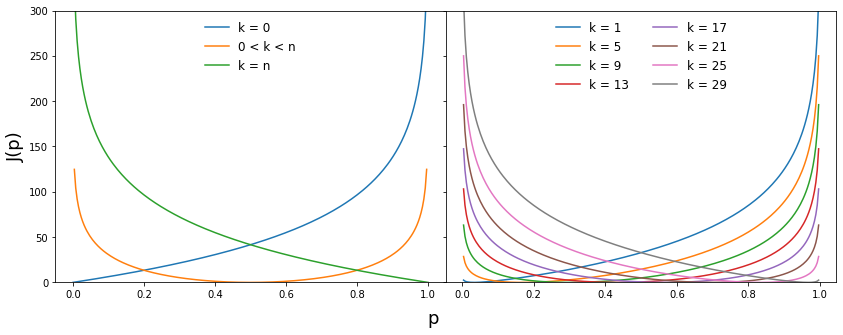

In [273]:
## Calculo y grafico la funcion de coste

nn = 30
kk = 15
p_est = kk/nn

p = np.linspace(0, 1, 256)

# Calculo la funcion de coste para los casos k = 0, 0<k<n y k = n
j_kn = 2*nn*(p_est*np.log(p_est/p) + (1 - p_est)*np.log((1 - p_est)/(1 - p)))
j_k0 = -2*nn*np.log(1 - p)
j_k1 = -2*nn*np.log(p)

# Grafico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.subplots_adjust(wspace=0)

ax1.plot(p, j_k0, label = 'k = 0')
ax1.plot(p, j_kn, label = '0 < k < n')
ax1.plot(p, j_k1, label = 'k = n')

for ki in np.arange(1, 30, 4): 
    p_est = ki/nn
    j_kn = 2*nn*(p_est*np.log(p_est/p) + (1 - p_est)*np.log((1 - p_est)/(1 - p)))
    ax2.plot(p, j_kn, label = 'k = {}'.format(ki))

ax2.tick_params(labelleft=False)

ax1.set_ylim(0, 300)
ax2.set_ylim(0, 300)

ax1.legend(loc = 'best', fontsize = 12, frameon = False)
ax2.legend(loc = 'best', ncol=2, fontsize = 12, frameon = False)

ax1.set_ylabel('J(p)', fontsize = 18)
fig.text(0.5, 0.01, 'p', ha='center', fontsize = 18)

plt.show()

warnings.filterwarnings('ignore')

In [274]:
## Defino modelo y funcion de coste

def mod(x, theta):
    return 1/(1 + np.exp(-(x - theta[0])/theta[1]))

def funcion_costo(theta, xdata, ydata):
        costo = 0
        for (x1, y1, pruebas) in zip(xdata, ydata, n):

            if y1 == 0:
                costo += -2*pruebas*np.log(1 - y1)

            elif y1 == 1:
                costo += -2*pruebas*np.log(y1)

            else:
                mu1 = mod(x1, theta)
                costo += 2*pruebas*(y1 * np.log(y1/mu1) + (1 - y1) * np.log((1 - y1)/(1 - mu1)))

        return costo

In [275]:
## Realizo ajuste por minimizacion

xfit = x
yfit = k/n

J = lambda theta: funcion_costo(theta, xfit, yfit)  

res = minimize(J, x0 = (0.5, 0.1))
# print(res)

param = res.x
cov = 2 * res.hess_inv
er = np.sqrt(np.diag(cov))
rho = cov[0][1]/(er[0]*er[1])

# Escribo resultados de los parametros y coeficiente de correlacion
print('a = {} ± {}'.format(round(param[0], 2), round(er[0], 2)))
print('b = {} ± {}'.format(round(param[1], 2), round(er[1], 2)))
print('ρ = {}'.format(round(rho, 2)))

a = 0.57 ± 0.02
b = 0.13 ± 0.01
ρ = 0.05


In [276]:
## Parámetros de bondad de ajuste

chi2_bondad = res.fun
grados = len(xfit) - len(param)
pvalor = chi2.sf(chi2_bondad, grados)

# Escribo resultados de parametros de bondad de ajuste y grados de libertad
print('χ² ajuste = {}'.format(round(chi2_bondad, 2)))
print('Grados de libertad = {}'.format(grados))
print('p - valor = {} %'.format(round(pvalor*100, 1)))

χ² ajuste = 14.41
Grados de libertad = 18
p - valor = 70.2 %


In [277]:
## Calculo banda de error

mu_est = mod(x, res.x)

grad_theta1 = - mu_est * (1 - mu_est) * (1 / param[1])
grad_theta2 = - mu_est * (1 - mu_est) * ((x - param[0]) / param[1]**2) 

grad = np.column_stack((grad_theta1, grad_theta2))
var_mu_est = np.einsum("ki,ij,kj->k", grad, cov, grad)

sigma_mu_est = np.sqrt(var_mu_est)

[]

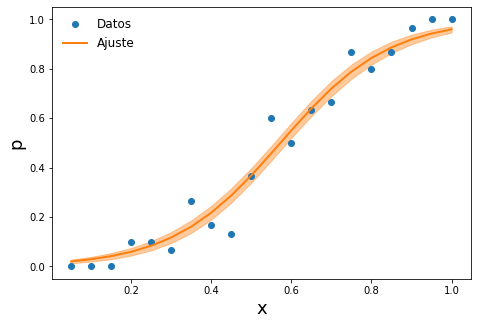

In [278]:
## Grafico datos y ajuste

mu_est = mod(x, res.x)

plt.figure(figsize=(7.5, 5))

plt.plot(x, k/n, 'o', label = 'Datos')
plt.plot(x, mu_est, lw = 2, label ='Ajuste')

plt.fill_between(x, mu_est - sigma_mu_est, mu_est + sigma_mu_est, color='tab:orange', alpha=0.4)

plt.xlabel('x', fontsize = 18)
plt.ylabel('p', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 12, frameon = False)

plt.plot()